# Baseline submission using Facenet

This notebook demonstrates how to use the `facenet-pytorch` package to build a rudimentary deepfake detector without training any models. It also demonstrates a method for (1) loading all video frames, (2) finding all faces, and (3) calculating face embeddings at over 30 frames per second (or greater than 1 video per 10 seconds).

The following steps are performed:

1. Create pretrained facial detection (MTCNN) and recognition (Inception Resnet) models.
  * See the following kernel for a strided implementation of MTCNN that is able to process all frames in each video: https://www.kaggle.com/timesler/facenet-pytorch-mtcnn-process-every-frame
  * See the following kernel for a performance comparison for different face detection implementations: https://www.kaggle.com/timesler/comparison-of-face-detection-packages
1. For each test video, calculate face feature vectors for **ALL** faces in each video.
1. Calculate the distance from each face to the centroid for its video.
1. Use these distances as your means of discrimination.

For (much) better results, finetune the resnet to the fake/real binary classification task instead - this is just a baseline. Alternatively, I'm sure there is much more interesting things that can be done with the feature vectors.

## Install dependencies

In [1]:
# Install facenet-pytorch
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl

from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p $torch_home/checkpoints/
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth $torch_home/checkpoints/vggface2_DG3kwML46X.pt
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth $torch_home/checkpoints/vggface2_G5aNV2VSMn.pt

ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'D:\\kaggle\\input\\facenet-pytorch-vggface2\\facenet_pytorch-2.2.7-py3-none-any.whl'



Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Processing d:\kaggle\input\facenet-pytorch-vggface2\facenet_pytorch-2.2.7-py3-none-any.whl


The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


## Imports

In [6]:
import os
import glob
import time
import torch
import torchvision
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


## Create MTCNN and Inception Resnet models

Both models are pretrained. The Inception Resnet weights will be downloaded the first time it is instantiated; after that, they will be loaded from the torch cache.

In [2]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
# resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

## Process test videos

After defining a few helper functions, this code loops through all videos and passes **_all_** frames from each through the face detector followed by facenet. Finally, we calculate the distance from the centroid to the extracted feature for each face.

In [3]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

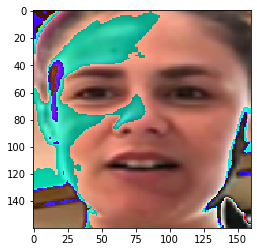

Frames per second (load+detect+embed):   5.84


In [9]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames = glob.glob('E:/Database/DFDC/dfdc_train_part_0/aaqaifqrwn.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            face = faces[2].cpu().clone()
            face = face.squeeze(0)
            face = torchvision.transforms.ToPILImage()(face)
            plt.imshow(face)
            plt.pause(0.001)
            # Calculate embeddings
#             X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

## Predict classes

The below weights were selected by following the same process as above for the train sample videos and then using a logistic regression model to fit to the labels. Note that, intuitively, this is not a very good approach as it does nothing to take into account the progression of feature vectors throughout a video, just combines them together using the weights below. This step is provided as a placeholder only; it should be replaced with a more thoughtful mapping from a sequence of feature vectors to a single prediction.

In [ ]:
bias = -0.2942
weight = 0.68235746

submission = []
for filename, x_i in zip(filenames, X):
    if x_i is not None:
        prob = 1 / (1 + np.exp(-(bias + (weight * x_i).mean())))
    else:
        prob = 0.5
    submission.append([os.path.basename(filename), prob])

## Build submission

In [ ]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
submission.sort_values('filename').to_csv('submission.csv', index=False)

plt.hist(submission.label, 20)
plt.show()